[qpe_with_sampler](https://github.com/Qiskit/qiskit-ibm-runtime/blob/stable/0.11/docs/tutorials/qpe_with_sampler.ipynb)

# Lab 3 : Diving Into Quantum Algorithms
***

## Section 1: QPE


<img src="./resources/qpe_tex_qz.png" alt="QPE Circuit" />


As a reminder to you, the above figure outlines the Quantum Phase Estimation (QPE) circuit.  Below, we'll provide a few import statements and functions that you'll use throughout the lab.

In [5]:
import math

from qiskit import QuantumCircuit, Aer, execute
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import gcd
from qiskit.circuit.library import QFT

In [6]:
# QFT circuit
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)

    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit
#Inverse Quantum Fourier Transform
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)

### Step 1: Set up a QPE Circuit with four counting qubits



Let's pick a phase gate with $\theta = \frac{1}{3}$ as a simple example unitary to test creating a QPE circuit.  Here we'll use Qiskit's `PhaseGate` which applies $P|1\rangle{}=e^{i\lambda}|1\rangle{}$.  Since we want to examine QPE under a unitary with the form $U|1\rangle{}=e^{i2\pi \theta}$, we should set $\lambda=\frac{2\pi}{3}$.

Create a QPE circuit with four counting qubits and name the circuit `qpe4`.  It may be helpful to define two `QuantumRegister` objects, one for the "system" where the unitary will be applied and one for where the phase information will be stored.  Feel free to reference the Qiskit Textbook's chapter on [Quantum Phase Estimation](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation#getting_more_precision).

It should look something like this (note that because Qiskit uses little endian notation, the ordering of the controlled-$U$ gates are different):

<img src="./resources/qpe4_circuit.png" alt="QPE 4 Phase Circuit" style="width: 1000px;"/>


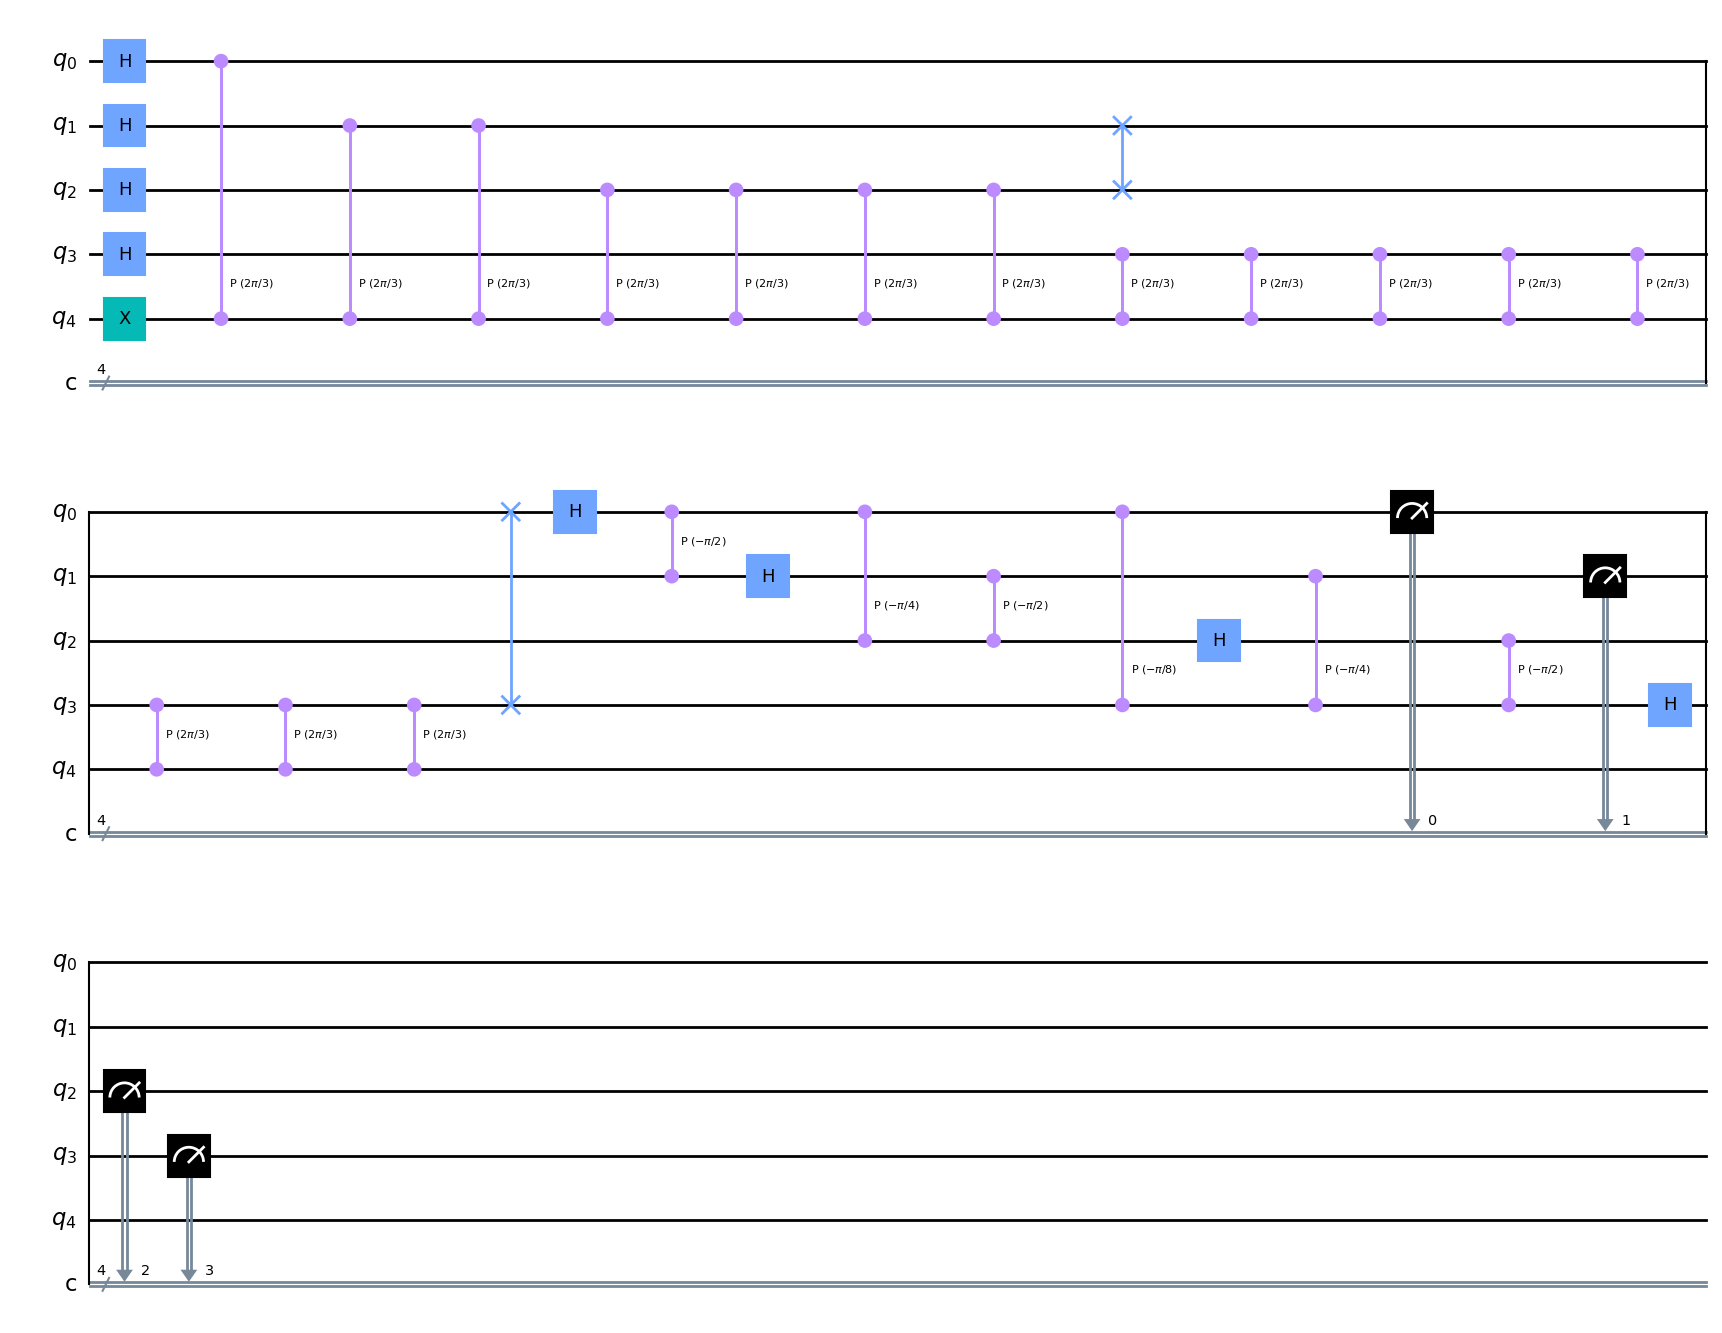

In [7]:
phase_register_size = 4
qpe4 = QuantumCircuit(phase_register_size+1, phase_register_size)

### Insert your code here
for qubit in range(phase_register_size):
    qpe4.h(qubit)

# Prepare our eigenstate |psi>:
qpe4.x(4)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(phase_register_size):
    for i in range(repetitions):
        qpe4.cp(angle, counting_qubit, phase_register_size);
    repetitions *= 2

# Do the inverse QFT:
#qpe4= qpe4.compose(QFT(phase_register_size, inverse=True), range(phase_register_size))
qft_dagger(qpe4,phase_register_size)

# Measure of course!
for n in range(phase_register_size):
    qpe4.measure(n,n)

qpe4.draw('mpl')

Now use the AerSimulator to simulate this circuit and plot the histogram of the results. Use 2000 shots.

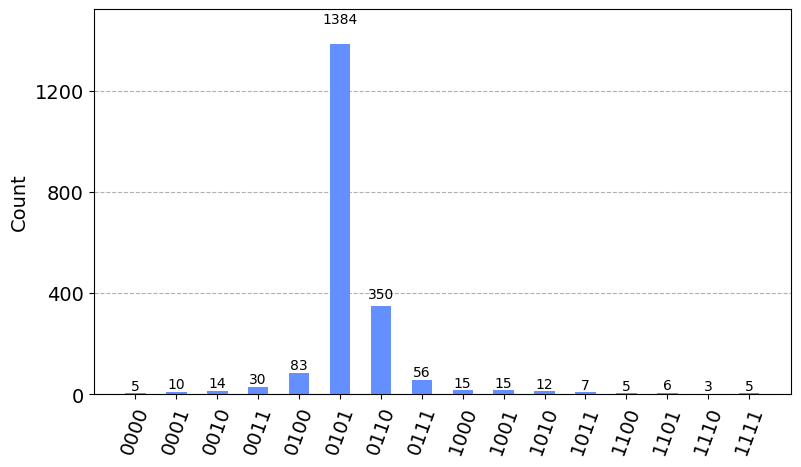

In [8]:
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
sim = Aer.get_backend('aer_simulator')
shots = 2000
count_qpe4 = execute(qpe4, sim, shots=shots).result().get_counts()
plot_histogram(count_qpe4, figsize=(9,5))

Next write a function to process the bit strings into the estimate of $\theta$.  Recall that the phase estimate is written in the form:

$$ \theta = 0.\theta_1\theta_2\theta_3...\theta_t = \frac{\theta_1}{2^1} + \frac{\theta_2}{2^2} + \frac{\theta_3}{2^3} + ... + \frac{\theta_t}{2^t} $$

where $\theta_i = \{0,1\}$.  What is the estimated phase?  What is the highest power of 2 this circuit can be accurate up to given your choice of the number of counting qubits (e.g. $2^{-2}$, $2^{-3}$, $2^{-4}$, etc.)?


In [9]:

#Grab the highest probability measurement
max_binary_counts = 0
max_binary_val = ''
for key, item in count_qpe4.items():
    if item > max_binary_counts:
        max_binary_counts = item
        max_binary_val = key
#max_binary_val = max(count_qpe4, key = count_qpe4.get)
## Your function to convert a binary string to decimal goes here
decimal_val = int(max_binary_val,2)


estimated_phase = decimal_val/2**phase_register_size
phase_accuracy_window = 2**(-phase_register_size)# highest power of 2 (i.e. smallest decimal) this circuit can estimate

## Step 2: Run on Noisy Hardware

Now run this circuit using your favorite backend!  Transpile this circuit a number of times (you pick how many) and pick the one with the lowest and highest circuit depth.

Transpile the circuit with the parameter optimization_level = 3 to reduce the error in the result. Qiskit by default uses a stochastic swap mapper to place the needed SWAP gates, which varies the transpiled circuit results even under the same runtime settings. Therefore, to achieve shorter depth transpiled circuit for smaller error in the outcome, transpile qpe4 multiple times and choose one with the minimum circuit depth. Select the maximum circuit depth one as well to compare against, name them `min_depth_qpe` and `max_depth_qpe`.


In [10]:
from qiskit_ibm_provider import IBMProvider
from qiskit.compiler import transpile

In [11]:
backend_name = "ibmq_manila"
provider = IBMProvider(instance='summer-school-4/group-1/6824921429')
provider.backends()
backend = provider.get_backend(backend_name)

# Run with 2048 shots
max_depth_qpe = transpile(qpe4, backend, optimization_level=1)
min_depth_qpe = transpile(qpe4, backend, optimization_level=3)

print('Original depth:', min_depth_qpe.depth(), 'Decomposed Depth:', max_depth_qpe.depth())

AccountNotFoundError: 'No default ibm_quantum account saved.'

In [ ]:
shots = 2000

#OPTIONAL: Run the minimum depth qpe circuit
job_min_qpe4 = backend.run(min_depth_qpe, sim, shots=shots)
print(job_min_qpe4.job_id())

#Gather the count data
count_min_qpe4 = job_min_qpe4.result().get_counts()
plot_histogram(count_min_qpe4, figsize=(9,5))

## Step 3: Try with a different $\theta$

Now try the same procedure with $\theta = \frac{1}{7}$.  Rewrite your code written above to create a function which generates a QPE circuit with $n$ register qubits.  How many register qubits storing the phase information are needed for the estimate to be accurate to within $2^{-6}$?

*Hint: It may be easier to iterate over different phase register sizes by creating a callable function. Perhaps call it* `qpe_circuit`

In [12]:

def qpe_circuit(register_size):
    # Your code goes here
    qpe = QuantumCircuit(register_size+1, register_size)
    for qubit in range(phase_register_size):
        qpe.h(qubit)
    # Prepare our eigenstate \psi>
    qpe.x(register_size)
    # Do the controlled-U operation
    angle = 2*np.pi/7
    repetitions = 1
    for counting_qubit in range(register_size):
        for i in range(repetitions):
            qpe.cp(angle, counting_qubit, register_size);
        repetitions *= 2

    # Do the inverse QFT:
    qpe= qpe.compose(QFT(register_size, inverse=True), range(register_size))
    # Measure of course!
    for n in range(register_size):
        qpe.measure(n,n)
    return qpe

In [4]:
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
reg_size = 5

qpe_check = qpe_circuit(reg_size)
sim =  Aer.get_backend('aer_simulator')
shots = 10000
count_qpe4 = execute(qpe_check, sim, shots=shots).result().get_counts()
plot_histogram(count_qpe4, figsize=(9,5))

NameError: name 'phase_register_size' is not defined

In [13]:
# Process the count data to determine accuracy of the estimated phase
max_binary_val = max(count_qpe4, key = count_qpe4.get)
## Your function to convert a binary string to decimal goes here
decimal_val = int(max_binary_val,2)


estimated_phase = decimal_val/2**reg_size
phase_accuracy_window = 2**(-reg_size)



estimated_phase
phase_accuracy_window

0.03125

In [ ]:
required_register_size = 5#your answer here

## Section 2: Shor's Algorithm
***

Here we will construct a set of functions to implement Shor's algorithm.  Remember that the goal of this algorithm is to find the prime factors of some large number $N$ and the key speedup this algorithm provides is by executing the period-finding part using a quantum computer.  This is where this section of the lab will focus.


Shor's algorithm is composed of the following steps:
1. Choose a co-prime $a$, where $a\in [2,N-1]$ and the greatest common divisor of $a$ and $N$ is 1.
1. Find the order (periodicity) of $a$ modulo $N$, i.e. the smallest integer $r$ such that $a^r\text{mod} N=1$
1. Obtain the factor of $N$ by computing the greatest common divisor of $a^{r/2} \pm 1$ and $N$.

## Step 1. Period Finding

To begin, we'll use the unitary operator: $$ U|y\rangle{} \equiv |ay\ \text{mod} N\rangle{} $$


and explore the superposition state:
$$
|u\rangle{} = \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{-\frac{2\pi ik}{r}}|a^k \text{mod}N\rangle{}
$$

Let's pick $a=3$ and $N=35$ as an example and investigate what the action of $U$ is on $|u\rangle{}$
\begin{align}
    U|u\rangle{} &= U\frac{1}{\sqrt{r}}\left( |1\rangle{} + e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} \right) \\
    & =\frac{1}{\sqrt{r}}\left( U|1\rangle{} + e^{-\frac{2\pi i}{r}}U|3\rangle{} + e^{\frac{-4\pi i}{r}}U|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}U|4\rangle{} + e^{\frac{-22\pi i}{r}}U|12\rangle{} \right) \\
    &= \frac{1}{\sqrt{r}}\left( |3\rangle{} + e^{-\frac{2\pi i}{r}}|9\rangle{} + e^{\frac{-4\pi i}{r}}|27\rangle{} + ... + e^{\frac{-20\pi i}{r}}|12\rangle{} + e^{\frac{-22\pi i}{r}}|1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}}\left( e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} + |1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}} |u\rangle{}.
\end{align}


This is a particularly helpful eigenvalue as it contains $r$.  In fact, it needs to be included in order to ensure the phase differences between the basis states are equal.  This is also not the only eigenstate of $U$.  For us to generalize further, we can multiply an integer $s$ to each of these phases, which will then show up in our eigenvalue

\begin{align}
    |u_s\rangle{} &= \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{\frac{-2\pi isk}{r}|a^k\text{mod} N\rangle{}} \\
    U|u_s\rangle{} &= e^{\frac{2\pi is}{r}}|u_s\rangle{}.
\end{align}


Now we have an eigenstate for each integer $0 \leq s \leq r$.  Notably, if we add up all of these eigenstates, the phases cancel all other basis states except $|1\rangle{}$ $$ \frac{1}{\sqrt{r}} \sum_{s=0}^{r-1}|u_s\rangle{} = |1\rangle{} $$.


Since any state in the computational basis can be written as a linear combination of these eigenstates, if we do QPE on $U$ using the state $|1\rangle{}$, we will measure a phase

$$ \phi = \frac{s}{r} $$
where $s$ is a random integer between $0$ and $r-1$.  Finally, we can use a method called the continued fraction algorithm on $\phi$ in order to find r.  The final circuit will look something like this



<img src="./resources/Shor_circuit.png" alt="Short Circuit" style="width: 1000px;"/>


***

Below we'll provide the unitary $U$ needed for solving this period finding problem with $a=7$ and $N=15$

$$
    U|y\rangle{} = |7y\text{mod}15\rangle{}.
$$

To create $U^x$ we will simply repeat the circuit $x$ times.  The cell below will construct this unitary

In [15]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

Confirm if the operator U works as intened by creating a quantum circuit with m=4 qubits. Prepare the inpute state $\Ket{y}$ representing any integer between o and 15 (remembering that Qiskit use little endian notations) such as $\Ket{1} = \Ket{0001}$, $\Ket{5} = \Ket{0101}$, etc. and apply $U\Ket{y}$. CHeck if the circuit produces the expecred outcomes for several inputs: $\Ket{1},\Ket{2},\Ket{5}$ (For example, the outcome for input state $\Ket{2}$ should be $\Ket{14} = \Ket{1110}$)
Run these circuits through the `aer_simulator` backend with 10000 shots, save the count data as `input_1`,`input_3` and `input_5`.

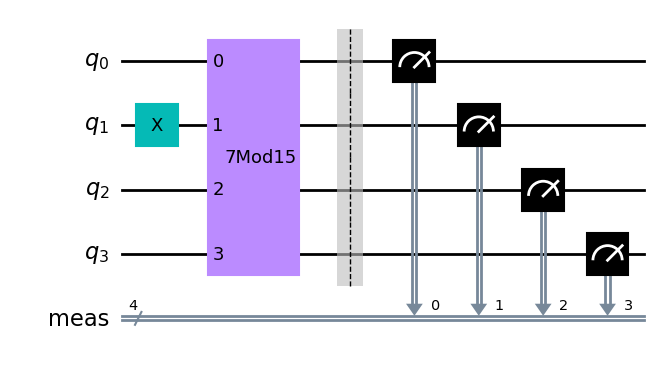

In [57]:
### your code goes here
qcirc = QuantumCircuit(m)
# we read from bottom to top |2> = |0010>
qcirc.x(1)
qcirc.append(U,[i for i in range(m)])
qcirc.measure_all()
qcirc.draw('mpl',fold=-1)

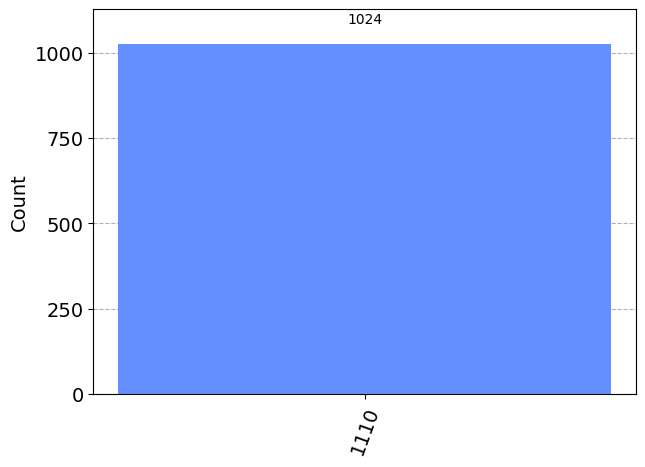

In [58]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qcirc,aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

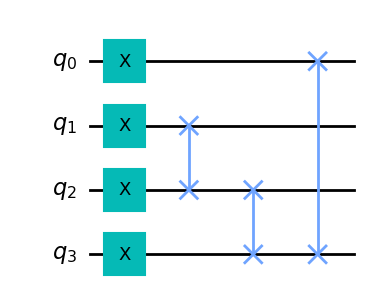

In [71]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))
U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)
U_qc.draw('mpl')

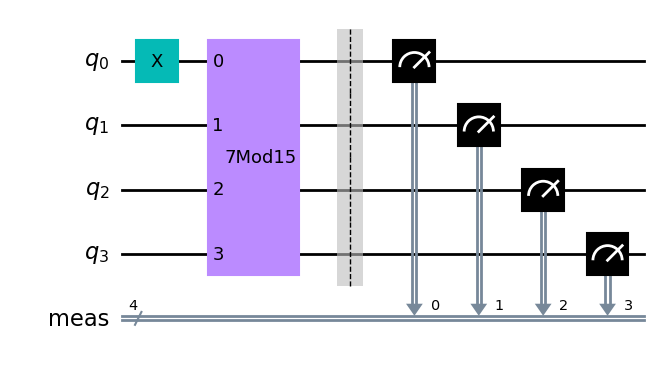

In [67]:
def U_y(m,decimal_number):
    qcirc = QuantumCircuit(m)
    #Initialize input state
    binary_number = format(decimal_number, "04b")
    for i in range(m):
        if binary_number[i]=='1':
            qcirc.x(m-1-i) # Qiskit uses little endian notation
    qcirc.append(U,range(m))
    qcirc.measure_all()
    return qcirc
qcirc_1 = U_y(m,1)
qcirc_2 = U_y(m,2)
qcirc_5 = U_y(m,5)
qcirc_1.draw('mpl',fold=-1)

In [68]:
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
sim = Aer.get_backend('aer_simulator')
shots = 20000

input_1 = execute(qcirc_1, sim, shots=shots).result().get_counts()  # save the count data for input 1
input_3 = execute(qcirc_2, sim, shots=shots).result().get_counts()
input_5 = execute(qcirc_5, sim, shots=shots).result().get_counts()# save the count data for input 5

print(input_1)
print(input_3)
print(input_5)

{'0100': 20000}
{'1000': 20000}
{'0101': 20000}


## Step 2. Implementing $U^{2^{m-1}}$

Now we'll use this controlled-$U$ to estimate the phase $\phi=\frac{s}{r}$.  But first, a quick point to note here.  It turns out a sequence of `7Mod15` gates produce the identity when executed by a multiple of 4 times.  To test this, create a quantum circuit implementing the `7mod15` gate $2^2$ times and run it on the `unitary_simulator` backend to obtain the matrix represenation of the gates in the circuit.  Verify $U^{2^2}=I$.

In [78]:
unitary_circ = QuantumCircuit(m)
unitary_circ.append(U,range(m))
unitary_circ.append(U,range(m))
unitary_circ.append(U,range(m))
unitary_circ.append(U,range(m))

sim = Aer.get_backend('unitary_simulator')
unitary = execute(unitary_circ, sim).result().get_unitary()


In [79]:
from qiskit.visualization import array_to_latex
array_to_latex(unitary)

<IPython.core.display.Latex object>

## Step 3. Finding $\phi$ and Continued Fractions


Now armed with a way to execute $U^{2^{m-1}}$, let's use it in the QPE circuit you created earlier.  Below is a function to construct a controlled-$U$ gate. Use $8$ qubits for the phase register and 4 qubits for the register which $U$ will act on, using the `aer_simulator` again, estimate the phase $\phi$ given an input state of $|1\rangle{}$.

*Hint: at each step in the QPE circuit, you'll need to construct a new `cU_multi` circuit and append it to the QPE circuit. There will be several estimates that have approximately equal probability.*

In [80]:
#This function will return a ControlledGate object which repeats the action
# of U, 2^k times
def cU_multi(k):
    sys_register_size = 4
    circ = QuantumCircuit(sys_register_size)
    for _ in range(2**k):
        circ.append(U, range(sys_register_size))

    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)

    cU_multi = U_multi.control()
    return cU_multi

In [90]:
N_COUNTS = 8  # number of counting qubits
a = 7

In [91]:
def shor_circuit(N_COUNT):
    shor_qpe = QuantumCircuit(N_COUNT+4, N_COUNT)#Create the QuantumCircuit needed to run with 8 phase register qubits
    # Initialize counting qubits
    #   in state |+>
    for q in range(N_COUNT):
        shor_qpe.h(q)

    # And auxiliary register in state |1>
    shor_qpe.x(N_COUNT)

    # DO controlled-U operations
    for q in range(N_COUNT):
        shor_qpe.append(cU_multi(q),[q] +[i+N_COUNT for i in range(4)])

    # DO inverse-QFT
    shor_qpe= shor_qpe.compose(QFT(N_COUNT, inverse=True), range(N_COUNT))
    # Measure circuit
    shor_qpe.measure(range(N_COUNT), range(N_COUNT))
    #shor_qpe.draw('mpl',fold=-1)  # -1 means 'do not fold'
    return shor_qpe

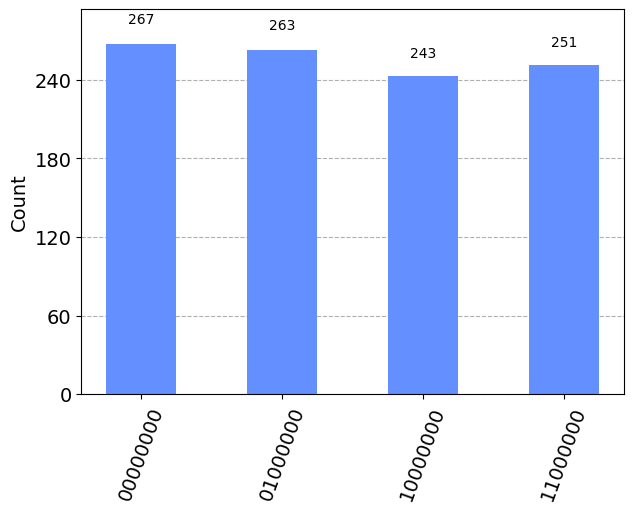

In [92]:
shor_qpe = shor_circuit(N_COUNTS)
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(shor_qpe, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

We can then find the integers $s$ and $r$ using the continued fractions algorithm.  Luckily python has built-in functionality for this using the `Fraction` function, where we will limit the denominator to $r<15$.  Use this to find the estimated $s$ and $r$ for each outcome you measured above.

In [93]:
from fractions import Fraction
print(Fraction(0.666), '\n')
print(Fraction(0.666).limit_denominator(15))

5998794703657501/9007199254740992 

2/3


In [97]:
measured_phases = []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNTS)  # Find corresponding eigenvalue
    measured_phases.append(phase)

shor_qpe_fractions = []

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    shor_qpe_fractions.append(frac)
print(shor_qpe_fractions)

[Fraction(0, 1), Fraction(3, 4), Fraction(1, 4), Fraction(1, 2)]


## Step 4. Putting it all together

Now let's put all of these steps together in order to factor the (very simple) number,  $N = 15$.  We'll continue with our example of $a=7$, remember that the phase we measure $s/r$ where $s$ is a random integer between $0$ and $r-1$ and:

$$
    a^r\text{mod}N = 1
$$

Then, once we have $r$, we can find a factor of $N$ by:

$$
    \left(a^r-1\right)\text{mod} N = 0
$$
which requires that $N$ must divide by $a^r-1$.  If $r$ is even, we can also write

$$
    a^r-1 = \left(a^{r/2}+1\right)\left(a^{r/2}-1\right).
$$

Put together a function called `shor_qpe` which takes an argument for $k$ (the number of counting qubits) and composes, runs, and processes Shor's algorithm to guess the factors.  Use an input state of $|y\rangle{}=|1\rangle{}$ for the phase estimation. (Note: The function `cU_multi()` only executes $|ay\ \text{mod}\ 15\rangle{}$ for $a=7$)

In [101]:
def qpe_7mod15(N_COUNT):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    #N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+N_COUNT) # And auxiliary register in state |1>
    # DO controlled-U operations
    for q in range(N_COUNT):
        qc.append(cU_multi(q),[q] +[i+N_COUNT for i in range(4)])

    # DO inverse-QFT
    qc= qc.compose(QFT(N_COUNT, inverse=True), range(N_COUNT))
    # Measure circuit
    qc.measure(range(N_COUNT), range(N_COUNT))
    #shor_qpe.draw('mpl',fold=-1)  # -1 means 'do not fold'
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    readings = execute(qc, aer_sim, shots=1, memory=True).result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase
phase =qpe_7mod15(8)
frac = Fraction(phase).limit_denominator(N)

In [100]:
def shor_qpe(k):

    a = 7
    FACTOR_FOUND = False
    ATTEMPT = 0
    #Step 1. Begin a while loop until a nontrivial guess is found
    while not FACTOR_FOUND:
        ATTEMPT +=1
        print(f"\nATTEMPT {ATTEMPT}:")
        #Step 2a. Construct a QPE circuit with m phase count qubits
        #  to guess the phase phi = s/r using the function cU_multi()
        #Step 2b. Run the QPE circuit with a single shot, record the results
        # and convert the estimated phase bitstring to decimal
        phase =qpe_7mod15(k)# Phase = s/r
        #Step 3. Use the Fraction object to find the guess for r
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        print(f"Result: r = {r}")
        if phase != 0:
            #Step 4. Now that r has been found, use the builtin greatest common deonominator
            guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
            print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
            #Step 5. For each guess in guesses, check if at least one is a non-trivial factor
            # i.e.  (guess != 1 or N) and (N % guess == 0)
            for guess in guesses:
                if guess not in [1,N] and (N % guess) == 0:
                    # Guess is a factor!
                    print("*** Non-trivial factor found: {guess} ***")
                    FACTOR_FOUND = True
                    return guesses

This lab was adapted from both the [Qiskit QPE Lab](https://learn.qiskit.org/course/ch-labs/lab-5-accuracy-of-quantum-phase-estimation#lab-3-0) as well as the [Qiskit Shor's Algorithm lab](https://learn.qiskit.org/course/ch-algorithms/shors-algorithm)
